In [73]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
import warnings
warnings.filterwarnings('ignore')
import re
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import hstack
from sklearn.multiclass import OneVsRestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('omw-1.4')
from nltk.stem import WordNetLemmatizer 
nltk.download('wordnet')
from wordcloud import WordCloud

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/sophiechance/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/sophiechance/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/sophiechance/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

In [3]:
resume_df = pd.read_csv('KaggleResumeDataSet.csv')
resume_df.head()

,Category,Resume
0,Data Science,Skills * Programming Languages: Python (pandas...
1,Data Science,Education Details \r\nMay 2013 to May 2017 B.E...
2,Data Science,"Areas of Interest Deep Learning, Control Syste..."
3,Data Science,Skills â¢ R â¢ Python â¢ SAP HANA â¢ Table...
4,Data Science,"Education Details \r\n MCA YMCAUST, Faridab..."


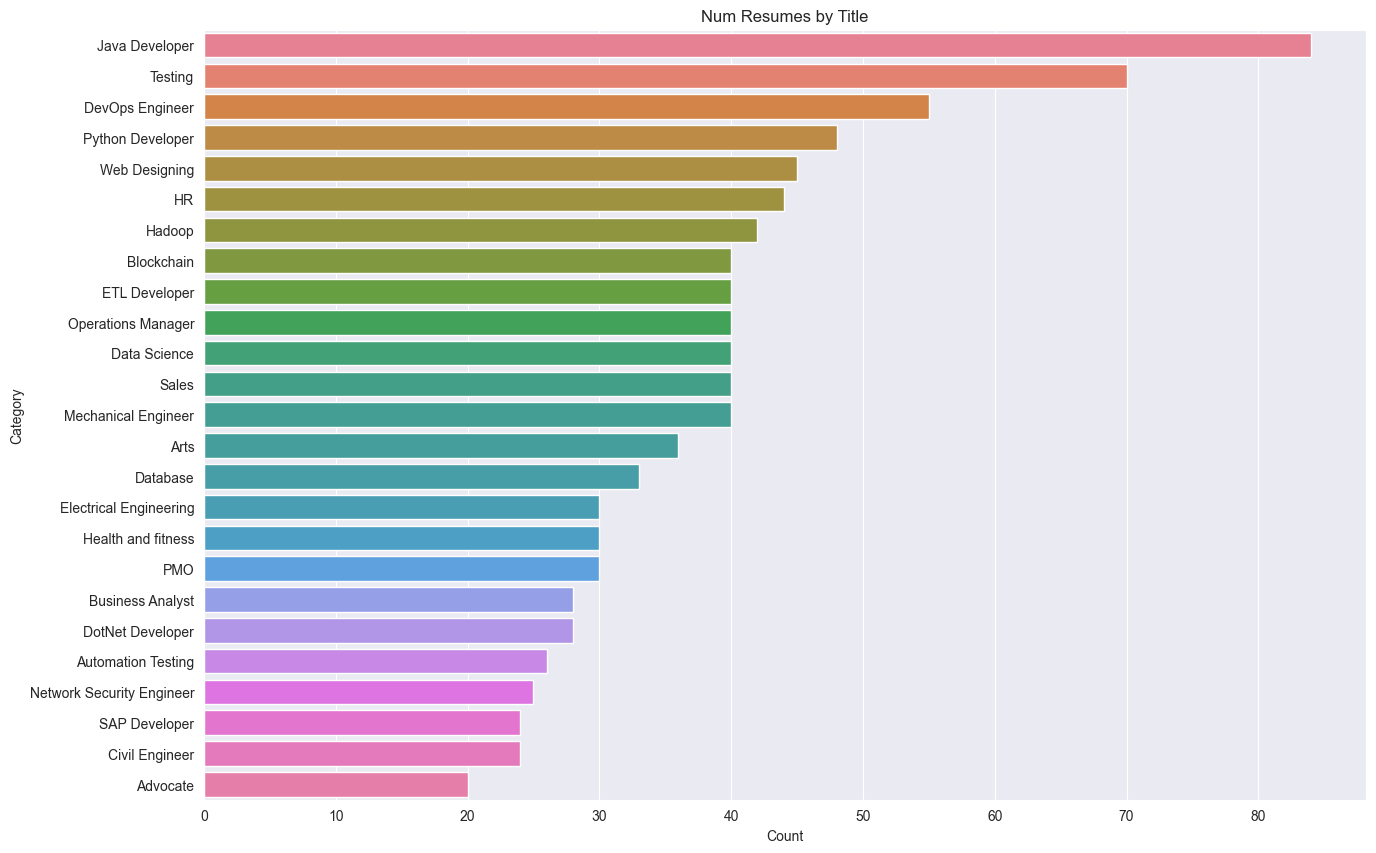

In [4]:
from turtle import title

dist_df = resume_df['Category'].value_counts().reset_index().rename({'index':'Category', 'Category':'Count'}, axis=1)

plt.figure(figsize=(15,10))
sns.barplot(x=dist_df['Count'], y=dist_df['Category'], palette='husl').set(title='Num Resumes by Title')
plt.show()

### Clean Dataset - Pre-processing

In [5]:
def cleanResume(resumeText):
    resumeText = re.sub(r'[^\x00-\x7f]',r' ', resumeText) # replace all non-ASCII characters
    resumeText = re.sub('http\S+\s*', ' ', resumeText)  # remove URLs
    # resumeText = re.sub('RT|cc', ' ', resumeText)  # remove RT and cc
    resumeText = re.sub('#\S+', '', resumeText)  # remove hashtags
    resumeText = re.sub('@\S+', '  ', resumeText)  # remove mentions
    resumeText = re.sub('[%s]' % re.escape("""!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~"""), ' ', resumeText)  # remove punctuations
    resumeText = re.sub('\s+', ' ', resumeText)  # remove extra whitespace
    resumeText = resumeText.lower()
    return resumeText

In [6]:
# Clean resume text
resume_df['Clean'] = ''
for i in range(len(resume_df)): 
    resume_df['Clean'][i] = cleanResume(resume_df['Resume'][i])

In [7]:
# Combine all resumes into one list of words
all_resume_text = ' '.join(map(str, list(resume_df['Clean'])))

tokenizer = nltk.tokenize.RegexpTokenizer('\w+')
resume_words = tokenizer.tokenize(all_resume_text)
print('There are', len(resume_words), 'words total')
print(resume_words[0:10])

There are 410841 words total
['skills', 'programming', 'languages', 'python', 'pandas', 'numpy', 'scipy', 'scikit', 'learn', 'matplotlib']


In [8]:
label = LabelEncoder()
resume_df['encoded_category'] = label.fit_transform(resume_df['Category'])
resume_df.head()

,Category,Resume,Clean,encoded_category
0,Data Science,Skills * Programming Languages: Python (pandas...,skills programming languages python pandas num...,6
1,Data Science,Education Details \r\nMay 2013 to May 2017 B.E...,education details may 2013 to may 2017 b e uit...,6
2,Data Science,"Areas of Interest Deep Learning, Control Syste...",areas of interest deep learning control system...,6
3,Data Science,Skills â¢ R â¢ Python â¢ SAP HANA â¢ Table...,skills r python sap hana tableau sap hana sql ...,6
4,Data Science,"Education Details \r\n MCA YMCAUST, Faridab...",education details mca ymcaust faridabad haryan...,6


In [9]:
# vectorizing text
# helpful article: https://medium.com/@cmukesh8688/tf-idf-vectorizer-scikit-learn-dbc0244a911a

resume_text = resume_df['Clean'].values
target = resume_df['encoded_category'].values
word_vectorizer = TfidfVectorizer(
    sublinear_tf=True,
    stop_words='english',
    max_features=1500)
word_vectorizer.fit(resume_text)
WordFeatures = word_vectorizer.transform(resume_text)

WordFeatures.shape

(962, 1500)

In [10]:
# print(WordFeatures)

In [11]:
# Separate train and test data
X_train, X_test, y_train, y_test = train_test_split(WordFeatures, target, random_state=24, test_size=0.2)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((769, 1500), (193, 1500), (769,), (193,))

In [ ]:
# # Model Training
# model = OneVsRestClassifier(KNeighborsClassifier())
# model.fit(X_train, y_train)

# # Prediction
# y_pred = model.predict(X_test)

# print(f'Training Accuracy   : {(model.score(X_train, y_train)*100).round(2)}%')
# print(f'Validation Accuracy : {(model.score(X_test, y_test)*100).round(2)}%')

In [50]:
# Spot Check Algorithms
models = []
models.append(('LR', LogisticRegression(solver='liblinear', multi_class='ovr')))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('SVM', SVC(gamma='auto')))

from sklearn.ensemble import RandomForestClassifier
models.append(('Random Forest', RandomForestClassifier()))

# evaluate each model in turn
results = []
names = []
for name, model in models:
	kfold = StratifiedKFold(n_splits=10, random_state=1, shuffle=True)
	cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring='accuracy')
	results.append(cv_results)
	names.append(name)
	print('%s: %f (%f)' % (name, cv_results.mean(), cv_results.std()))

LR: 0.994805 (0.008615)
KNN: 0.980519 (0.013308)
CART: 0.990875 (0.014326)
SVM: 0.088431 (0.005267)
Random Forest: 0.996104 (0.008316)


In [60]:
print(metrics.classification_report(y_test, y_test))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           1       1.00      1.00      1.00         9
           2       1.00      1.00      1.00         6
           3       1.00      1.00      1.00         9
           4       1.00      1.00      1.00         3
           5       1.00      1.00      1.00         3
           6       1.00      1.00      1.00         7
           7       1.00      1.00      1.00         6
           8       1.00      1.00      1.00        10
           9       1.00      1.00      1.00         6
          10       1.00      1.00      1.00        10
          11       1.00      1.00      1.00         8
          12       1.00      1.00      1.00         6
          13       1.00      1.00      1.00         6
          14       1.00      1.00      1.00         8
          15       1.00      1.00      1.00        16
          16       1.00      1.00      1.00         7
          17       1.00    

In [64]:
#Stop words are generally the most common words in a language.
#English stop words from nltk.
stopwords = nltk.corpus.stopwords.words('english')
resume_words_new = []
#Now we need to remove the stop words from the words variable
#Appending to words_new all words that are in words but not in sw
for word in resume_words:
    if word not in stopwords:
        resume_words_new.append(word)
print(len(resume_words_new))

318309


In [67]:
# Perform Lemmatization
wn = WordNetLemmatizer() 
lem_words=[]
for word in resume_words_new:
    word=wn.lemmatize(word)
    lem_words.append(word)

In [69]:
same=0
diff=0
for i in range(0,1832):
    if(lem_words[i]==resume_words_new[i]):
        same=same+1
    elif(lem_words[i]!=resume_words_new[i]):
        diff=diff+1
print('Number of words Lemmatized=', diff)
print('Number of words not Lemmatized=', same)

Number of words Lemmatized= 295
Number of words not Lemmatized= 1537


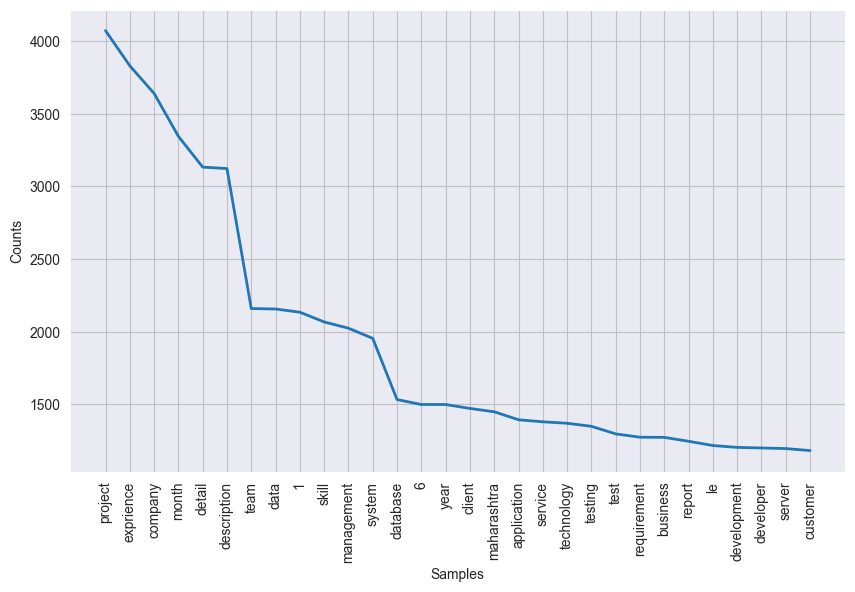

<AxesSubplot: xlabel='Samples', ylabel='Counts'>

In [75]:
#The frequency distribution of the words
freq_dist = nltk.FreqDist(lem_words)
#Frequency Distribution Plot
plt.subplots(figsize=(10,6))
freq_dist.plot(30)

In [71]:
# Now we generate wordcloud
res=' '.join([i for i in lem_words if not i.isdigit()])

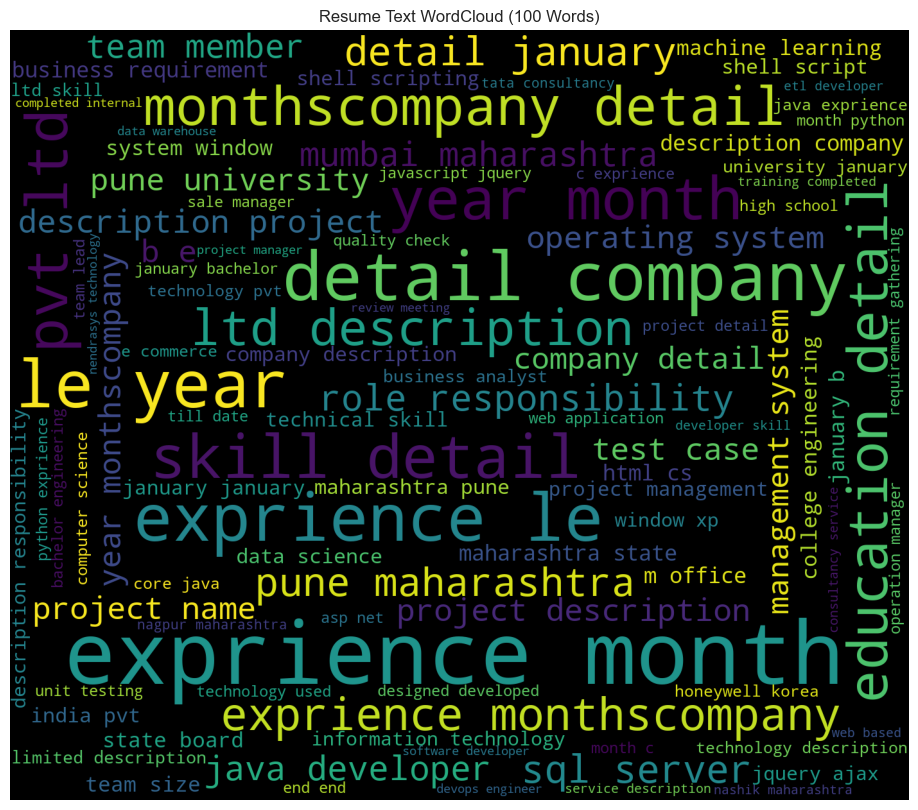

In [77]:
plt.subplots(figsize=(16,10))
wordcloud = WordCloud(
                          background_color='black',
                          max_words=100,
                          width=1400,
                          height=1200
                         ).generate(res)
plt.imshow(wordcloud)
plt.title('Resume Text WordCloud (100 Words)')
plt.axis('off')
plt.show()